# Table of Content <a id='toc'></a>


&nbsp;&nbsp;&nbsp;&nbsp;[Convention and definition of the problem for linear model](#0)

&nbsp;&nbsp;&nbsp;&nbsp;[1. Least Square Method](#1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Simple representation of the problem and how it is solved](#2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2.Underlying hypotheses of the Least Square fit](#3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3. Goodness of fit](#4)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4. Confidence interval and test statistics](#5)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.5. building and fitting OLS models with `statsmodels`](#4b)

&nbsp;&nbsp;&nbsp;&nbsp;[Exercise on a real dataset : model the effect of park frequentation on sparrow nest number with a cubic function](#6)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.6. Model choosing](#8)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.7 What to do when some hypothesis about OLS are not true](#7)

&nbsp;&nbsp;&nbsp;&nbsp;[Exercise : model choosing on the sparrow nuisance dataset](#9)

&nbsp;&nbsp;&nbsp;&nbsp;[Going further : interaction effects](#11)

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import scipy.stats as stats 
import pandas as pd
import numpy as np
from operator import itemgetter
import statsmodels
import statsmodels.api as sm


In [2]:
%matplotlib inline
import matplotlib
#matplotlib.use('nbagg') # enables interactive figures, where we can zoom and move

In [3]:
# a couple more configuration of the plotting engine
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=18)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In [4]:
%%javascript
// prevents output into scrollable frames
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>


[back to the toc](#toc)

<br>

# Convention and definition of the problem for linear model <a id='0'></a>


The problem we are interested in is the following:

We have measured a bunch of variables per individual, for $n$ individuals. 
We are interested in the relationship between one of this variable that we will call the **response variable** 
and the other variables that we will call **covariables**.

Let's illustrate this with the "diabetes" dataset, grabbed from Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499. (https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf).

It is described as : 
"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."


In [5]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

#this is our response variable
response=pd.DataFrame(diabetes['target'],columns=['disease_progression'])
response.head()

,disease_progression
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [6]:
## this is our covariable
covar=pd.DataFrame(diabetes['data'],columns=diabetes['feature_names'])
covar.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641



From a mathematical standpoint, we note the response variable vector $\pmb{y}$, and $\pmb{y}_i$ is a single element of that vector (*ie.* the reponse variable measured on a single individual).

Similarly, $\pmb X$ is the matrix of shape $(n,p)$ which contains the values of covariables. 
$\pmb{X}_i$ is a row in this matrix, which corresponds to the measures of the $p$ covariables for individual $i$.

\begin{equation*}
\pmb X = 
\begin{bmatrix}
X_{1,1} & X_{1,2} & ... & X_{1,p} \\
X_{2,1} & X_{2,2} & ... & X_{2,p} \\
 ... \\
X_{n,1} & X_{i,2} & ... & X_{n,p} \\
\end{bmatrix}
 ,\pmb y = 
\begin{bmatrix}
y_{1} \\
y_{2} \\
 ... \\
y_{n} \\
\end{bmatrix}
\end{equation*}

Furthermore, we will consider our response variable to actually be a random variable.
So each $y_i$ is in fact a realisation of a random variable $\pmb Y_i$.

Indeed our measurements are not perfect so there is some noise associated to it ($\epsilon$) : this why we decided to consider our response variable as a random variable. In mathematical term we are interested in a class of problem that we can write as :

$$\pmb{Y}_i=f(\pmb{X}_i)+\epsilon$$

The function $f$ is called the regression function, and today we will be interested in looking at a particular form of those function: **linear combination**.

A particular case of linear combination would be a single covariable with an intercept like :

$$y_i=\beta X_{i,1}+c$$

A more general case would have more covariables and would be written like:

$$f(\textbf{X}_i,\pmb{\beta})=\sum_{j} \beta_j X_{i,j}= \textbf{X}_{i}^{T}\pmb{\beta}$$

Where *$\pmb X_i$* is a vector of $p$ covariables associated to point individual $i$. And $\pmb{\beta}$ is a vector of $p$ coefficients (one for each covariable).

Note that for now nothing is said about the nature of the $X_{i,j}$. For example, some could be constant instead of being a variable (in that specific case they may as well be integrated in the $c$ constant).


In the case of our diabetes example, the response variable is $diseaseprogression$ and the covariables are 
$age , 	sex , bmi , bp, s1 , s2 , s3 , s4 , s5 , s6$.

So in the end, 
we are interested in finding a set of coefficients $\pmb \beta$ so that:

$$disease progression_0=\beta_1 age_0 + \beta_2 sex_0+\beta_3 bmi_0+\beta_4 bp_0+\beta_5 s1_0 +\beta_6 s2_0 + \beta_7 s3_0+\beta_8 s4_0+\beta_9 s5_0+\beta_10 s6_0+\beta_0$$

$$disease progression_1=\beta_1 age_1 + \beta_2 sex_1+\beta_3 bmi_1+\beta_4 bp_1+\beta_5 s1_1 +\beta_6 s2_1 + \beta_7 s3_1+\beta_8 s4_1+\beta_9 s5_1+\beta_10 s6_1+\beta_0$$

$$......$$

$$disease progression_n=\beta_1 age_n + \beta_2 sex_n+\beta_3 bmi_n+\beta_4 bp_n+\beta_5 s1_n+\beta_6 s2_n + \beta_7 s3_n+\beta_8 s4_n+\beta_9 s5_n+\beta_10 s6_n+\beta_0$$

Let's say for now we are only interest in $bmi$ (Body Mass Index) to predict disease progression. 
Then the kind of outcome we want of this analysis is our ability to understand the data linearly like that, which can be summarized by our ability to produce this kind of plots:

slope also called beta in our notation=  949.4352603840384
intercept also called c in our notation=  152.13348416289617


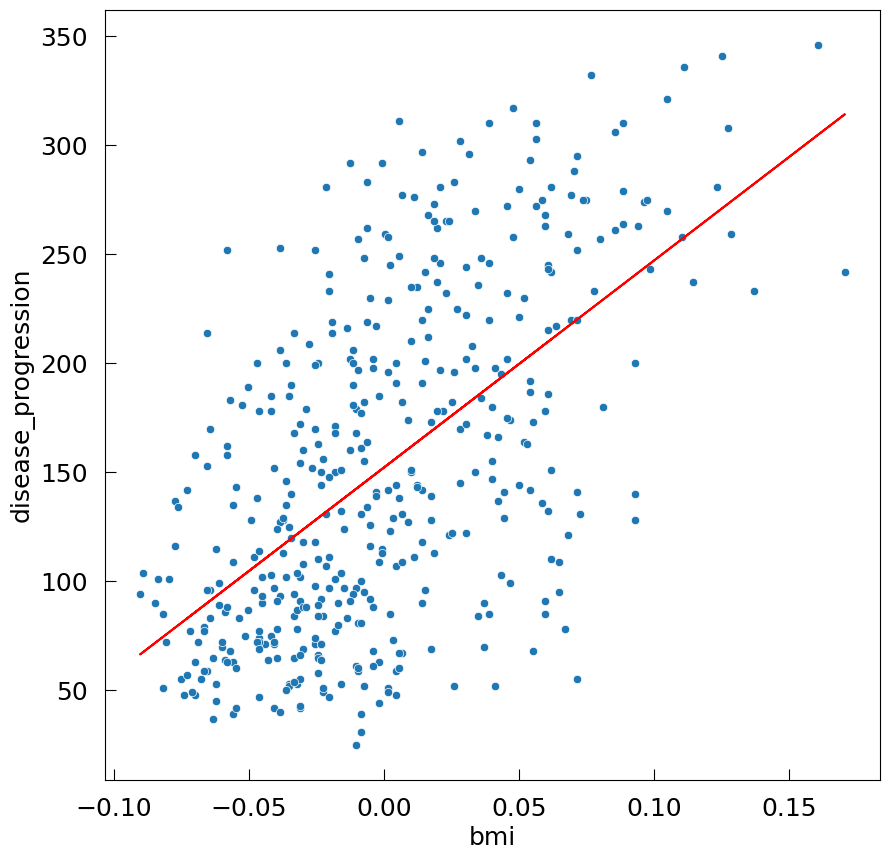

In [7]:
#pulling all the data together in the same dataFrame
df_diabetes = pd.concat( [covar , response] , axis = 1 ) 

x = df_diabetes['bmi'] # covariable bmi
y = df_diabetes['disease_progression'] # response variable disease progression


fig, ax = plt.subplots( figsize = (10,10)) #setup graphical windows
sns.scatterplot(x=x,y=y) # plot x versus y

#linear regression explaining disease progression thanks to bmi
slope , intercept , r , pval , stderr = stats.linregress(x,y)
##don't mind how we did the regression for now, this is just for showcasing
print("slope also called beta in our notation= ",slope)
print("intercept also called c in our notation= ",intercept)

#now that we have the outcome iof the regression which is in this case a slope and
#an intercept we can calulate what the model will predict as a disease progression given a bmi value
yPredict = x * slope + intercept 

ax.plot( x , yPredict , color = 'red')#the outcome of the regression is this red line

So of course now the game becomes how to choose the best vector of parameters $\pmb{\beta}$. For that we will discuss two main methods (sorry Bayesian people...):
- Least Square fit
- Maximum Likelihood

It is important to realize that these two are just **methods to find a good fit**,
they are somewhat disconnected from the actual model we use to represent the data.



Indeed, underlying those different methods there are many possible models. We will discuss:

- Linear Models
- Generalized Linear Models

As their name entails, **Generalized Linear Models** (GLMs for short) are just a generalization of the simple linear models, where we can perform a transformation on our linear combination (such as a logarithm for instance), and specify which diststribution to use to generate the "noise" (such as a poisson distribution for instance).

But, we will se that later. For now, let's focus on the simple **linear model**, which we can solve with the **least square fit** method



[back to the toc](#toc)

<br>

# 1. Least Square Method <a id='1'></a>


In the least square method we are interested in making the smallest overall square error between our model and the response variable.

Typically we want to find the vector of parameters $\beta$ that minimizes the objective function :

$$S(\pmb\beta)=\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2=\sum_i \epsilon_i^2$$

Here the sum is over $n$, which counts the number of individuals.

in mathematical terms you are looking for :

$$\hat{\pmb\beta}=\text{arg min}_{\pmb\beta}S(\pmb\beta)$$


> The hat $\hat{.}$, is a notation we use to denote our estimate of the true value of something. So in that sense $\hat{\pmb\beta}$ is the estimate of the "real" coefficient values, and $\hat{Y}$ is the estimation of $Y$ given by our model (also called the model predictions).



Let's see how that work on a toy example 


[back to the toc](#toc)

<br>

## 1.1 Simple representation of the problem and how it is solved <a id='2'></a>


#### Toy example

Let's play with a toy example where we know the solution. 

We simulate a response variable that can be written $y=3x$, so with a single covariable. We also add some gaussian noise on top of that. 

We are going to check if the Ordinary Least Square (OLS) method could actully find this coefficient of 3.

Text(0, 0.5, 'Y')

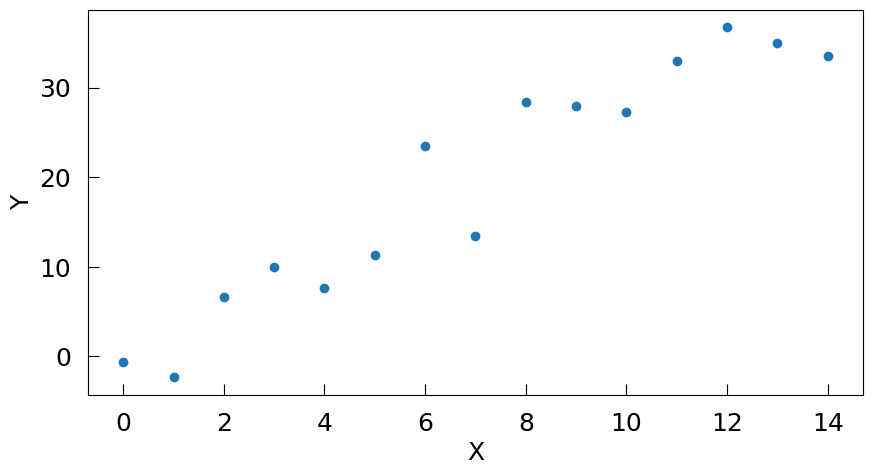

In [8]:
from matplotlib import collections  as mc

## let's create some data to play with 
slopeReal = 3 # the real slope is 3
noise = 3 #noise strength

x = np.arange(15) # 15 points for x
y = slopeReal * x + noise * np.random.randn(len(x)) # y = beta * x + some noise (no intercept here)

# plot the data
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(x,y, 'o' )
ax.set_xlabel("X")
ax.set_ylabel("Y")

**The challenge of least square regression is to find the slope that minimizes the squared error
let's try 3 possible values for the slope here : 2, 3 and 4**

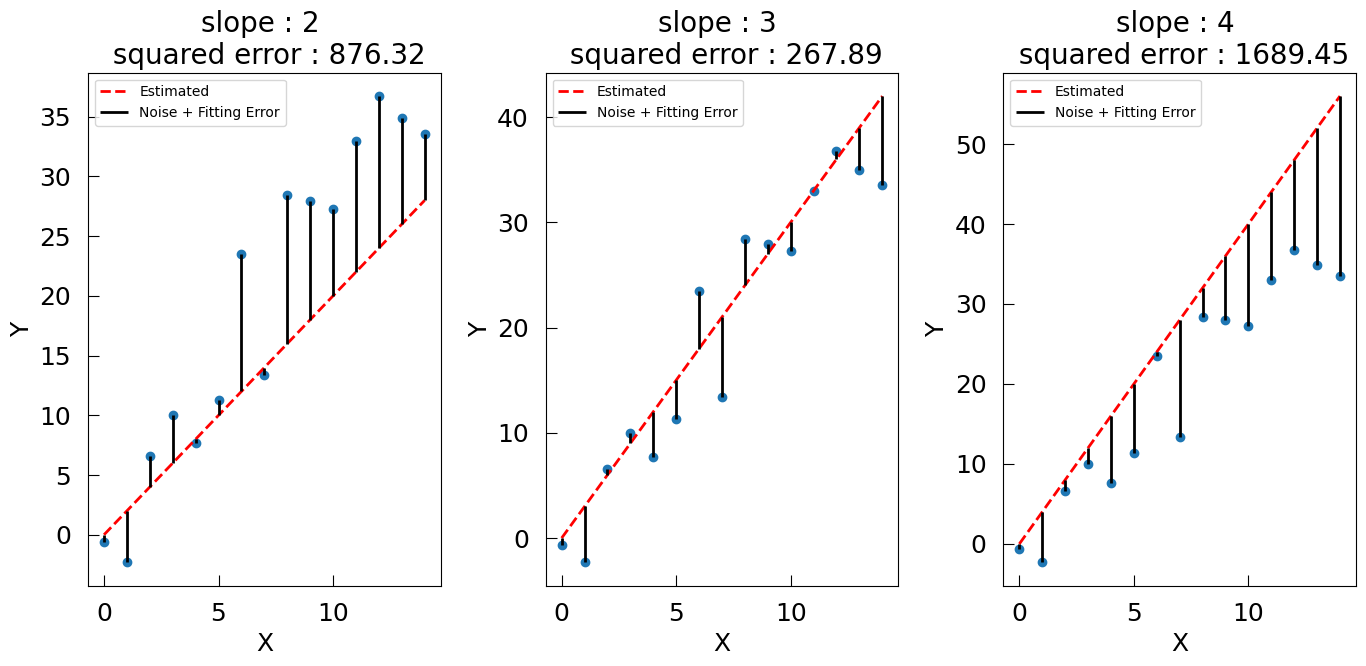

In [9]:

estimatedSlopes = [2,3,4]

fig, ax = plt.subplots(ncols=len(estimatedSlopes) , figsize = (14,7))

for i,slopeEstimate in enumerate(estimatedSlopes): # for each slope we want to test
    
    yPredicted = slopeEstimate * x # prediction of y given the estimated slope and values of x

    # error of the prediction -> sum of squared difference between observation and prediction
    predictionSquaredError = sum( ( yPredicted - y )**2 ) 

    #base plot
    ax[i].plot(x,y, 'o')
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    
    ax[i].plot(x,yPredicted, 'r--' , linewidth=2,label='Estimated') #plotting the prediction

    # now, let's represent the fitting error as segments between real and estimated values
    Real = [i for i in zip(x,y)]
    Predicted = [i for i in zip(x,yPredicted)]
    lc = mc.LineCollection(zip(Real,Predicted) , colors='black',linewidths=2,label='Noise + Fitting Error')
    ax[i].add_collection(lc)
    
    ax[i].set_title('slope : {} \n squared error : {:.2f}'.format(slopeEstimate,predictionSquaredError) ,
                    fontsize=20)
    ax[i].legend(fontsize=10)
plt.tight_layout()


**micro-exercise** : based on the 3 plot just above. Which one would you choose and why?

<br>

<br>


We could try to generalize this approach and test a lot of possible slope and then choose the best one (the one giving the lowest SSE).

slope estimate with the smallest squared error (noise + fitting error) :  2.76


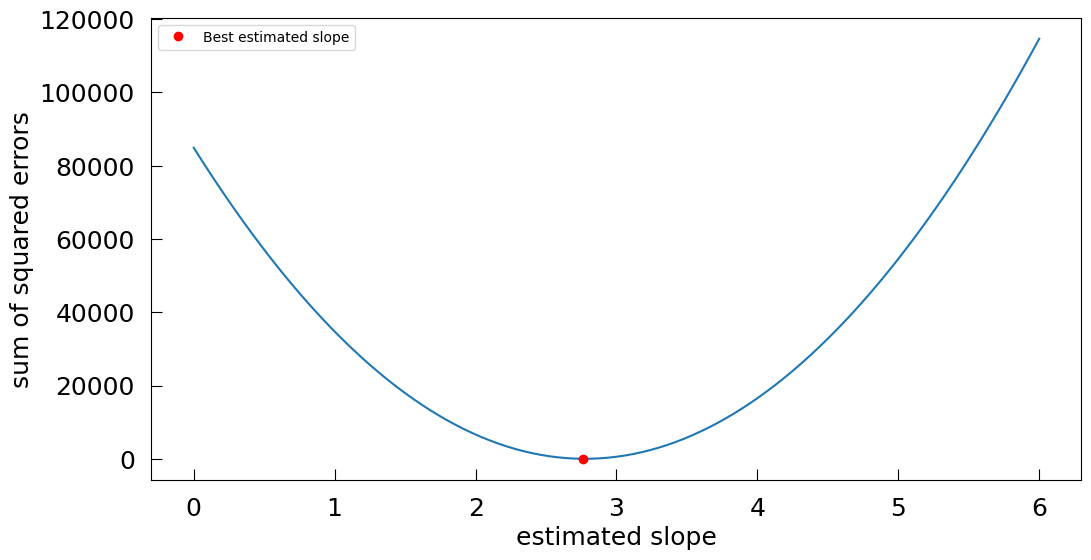

In [10]:
possibleSlopes = np.linspace(0,6,101)# trying a hundred slopes between 0 and 6
errors = []
for sl in possibleSlopes: # we compute the sum of squared error for each slopes
    yPred = sl*x
    errors.append( sum( yPred - y )**2 )

fitted_slope=possibleSlopes[ np.argmin( errors ) ] # we use np.argmin to find the best slope
min_err=min(errors)

#plotting 
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(possibleSlopes , errors )
ax.plot(fitted_slope , min_err,'ro' ,label='Best estimated slope')
ax.legend(loc='best',fontsize=10)

plt.xlabel('estimated slope')
plt.ylabel('sum of squared errors')
print( 'slope estimate with the smallest squared error (noise + fitting error) : ', fitted_slope )
#plt.tight_layout()

**Mini-exercice : what are the defaults of this method to find the best $\beta$ ?**

<br>


<br>


<br>



While we could use various optimization algorithms to find the best value for $\beta$, 
when the system is overdetermined (*i.e.*, you have more points than coefficients $\beta_i$) an analytical solution exists. It is of the form:

$$\hat{\pmb\beta}=(\pmb X^T \pmb X)^{-1}\pmb X^T \pmb Y$$


[back to the toc](#toc)

<br>

## 1.2.Underlying hypotheses of the Least Square fit <a id='3'></a>

There are a couple of important hypothesis behind this method:

- **Correct specification** : have a good incentive for the function you use
- **Strict exogeneity** : the errors are centered around the true value of y
- **No linear dependance** : you can not reconstruct one of your covariable by summing a subset of your covariables with some set of constant weights 
- **Spherical errors**: 
    - Homoscedasticity : the spread of the error is the same along the curve.
    - No autocorrelation : error are not correlated along the curve.
        

        
To illustrate **Strict exogeneity** and **Spherical errors**, here is a plot of the errors on the diabetes model with $bmi$ :

error
mean    -0.000
median  -8.649
Q1 : -43.572 , Q3 : 46.344


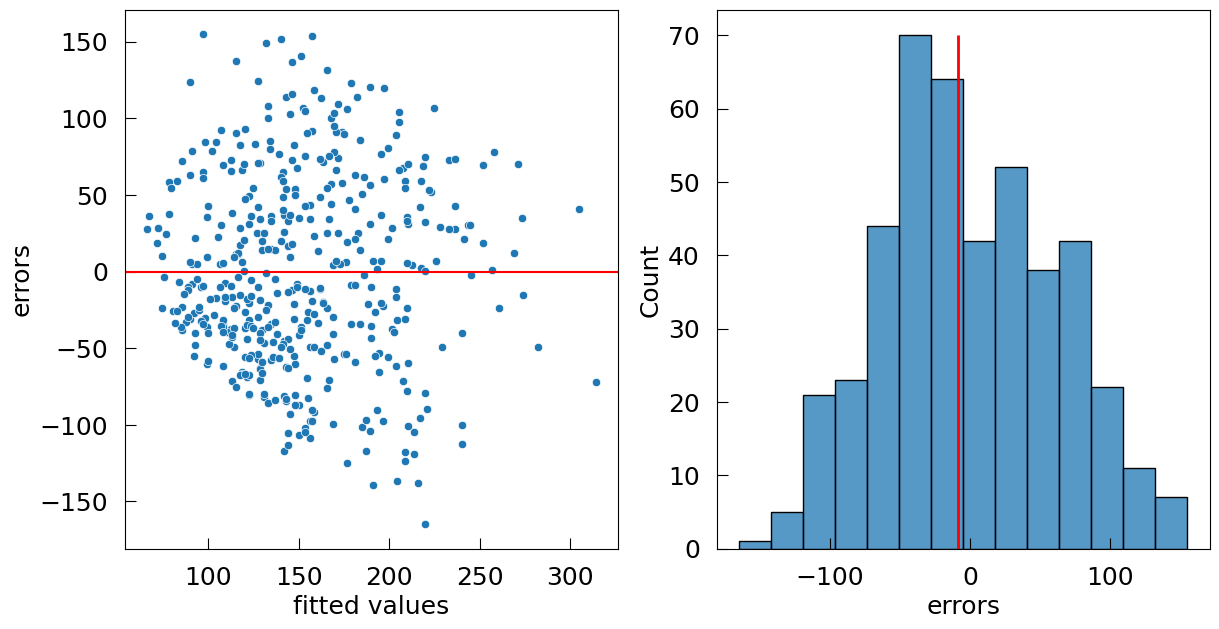

In [11]:
x = df_diabetes['bmi'] # covariable bmi
y = df_diabetes['disease_progression'] # response variable disease progression
slope , intercept , r , pval , stderr = stats.linregress(x,y)
fitted_y = (x*slope+intercept)
errors = y - fitted_y

fig, ax = plt.subplots(ncols=2, figsize = (14,7)) #setup graphical windows
sns.scatterplot(x=fitted_y,y=errors , ax=ax[0]) # plot the errors along x
ax[0].axhline(0,color='red')
ax[0].set_ylabel('errors')
ax[0].set_xlabel('fitted values')
sns.histplot(errors , ax=ax[1]) # plot an histogram of the errors
ax[1].vlines( np.median( errors ) ,0,70 , color="red", linewidth = 2)
ax[1].set_xlabel('errors')

print( "error" )
print( "mean    {:.3f}".format(errors.mean()) )
print( "median  {:.3f}".format(np.median( errors )) )
print( "Q1 : {:.3f} , Q3 : {:.3f}".format(*np.quantile( errors , [0.25,0.75] ) ) )

The errors seems centered around 0 and there is no definite pattern that would allow us to reject outright the hypotheses of the Least Square fitting. We shall see later on how to actually test these using specific statistical tests.

The right panel also seems to suggest that our errors could follow something that looks like a normal distribution.

**Normality is not strictly needed for Least Square fitting, neither for the variables nor for their errors.** 
However you may need that hypothesis of normality of errors downstream in your analysis, in particular when using a test statistic to determinate the significance of your parameter


Additionnaly, if your errors are normally distributed, then Least Square fitting and Maximum Likelihood are equivalent, showing that your method for choosing $\pmb\beta$ is efficient and sound.

<br>

A model where things go wrong, for instance where there is heteroskedascticity, could look something like that instead:

Text(0.5, 0, 'fitted values')

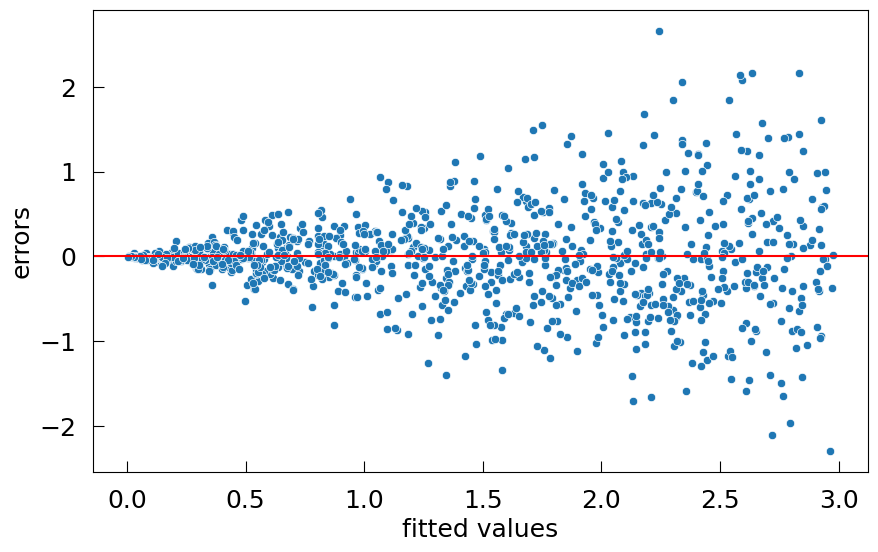

In [12]:
x = np.random.random(1000)
y = 3 * x + x * np.random.randn(len(x))  # the noise strength now depends on x.
slope , intercept , r , pval , stderr = stats.linregress(x,y)
fitted_y = (x*slope+intercept)
errors = y - fitted_y 

fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(x=fitted_y,y=errors , ax=ax) # plot the errors along x
ax.axhline(0,color='red')
ax.set_ylabel('errors')
ax.set_xlabel('fitted values')

<br>   

---  

<br>

Finally, within that set of constraints and even if the method is called Linear Models, it is possible to **fit polynomials**. To do so you just have to precompute the monomials and add them to your set of covariables.

For example :

$y=\beta x +c$ is a linear combination of x

$y=\beta_{1}x+\beta_{2}x^{2}+\beta_{3}x^{3}$ is still a linear combination of covariables x, $x^{2}$ and $x^{3}$, and **X** becomes {$x,x^2,x^3$\}




[back to the toc](#toc)

<br>

## 1.3. Goodness of fit <a id='4'></a>

By definiton, the least square fit minimizes the Sum of Square Errors : $SSE=\sum (y_i-\hat{y_i})^2)$.

It is still important to assess the goodness of fit of your model, for instance to get an idea if you capture most of the variance of your response variable or to compare models between one-another.

The first metric use to do so is the **Mean Square Error** (MSE), which is defined as follow:

<br>

$$MSE=\frac{SSE}{n-2}$$ 

Why $n-2$? here are [elements of answer](https://stats.stackexchange.com/questions/378407/why-error-sum-of-squares-has-n-2-df-possibly-not-duplicate-please-read-on-r). Anyway this accounts for what your model is missing. 
That could be the simple inherent variance induced by the noise term or the noise term and a missing term that your model doesn't take into account. By its nature, this metric makes it hard to compare between different hypothetical fitting models or different dataset.

A better normalized metric is the **adjusted coefficient of determination $\pmb R^2_a$**. 
The adjusted part is very necessary when we work in the context of multiple linear regression (more than one covariable). 

Let's start by defining the coefficient of determination $\pmb R^2$. 
This coefficient partitions the variance present in your data between what is taken into account by your model and what is not.

$$R^2=1-\frac{SSE}{SST}$$ <br>, where $SSE=\sum_i (y_i-\hat{y_i})^2$) and SST in the Sum of Squares Total ($\sum_i (y_i-\bar{y})^2$)

For the adjusted coefficient of determination you have to take into account that SSE and SST don't have the same degree of freedom and you should adjust for that.

$$R^2_a=1-\frac{n-1}{n-p}(1-R^2)$$, with $p$ the number of covariables and $n$ the number of individuals.

> Note : you can see that when there is only one covariable then $R^2_a = R^2$

In [13]:
SSE = sum( errors**2 )
MSE = SSE/(len(y)-2)
SST = sum( ( y - np.mean(y) )**2 )               # sum of square total
R2 =  1 - SSE/SST                                # coefficient of determination
R2a = 1 - ( (len(y)-1)/(len(y) - 2) ) * (1 - R2) # here, we have 2 parameters : intercept and slope for bmi
print( """bmi and disease progression model 
 - SSE: {:.3f}
 - MSE: {:.3f}
 - R2:  {:.5f}
 - R2a: {:.5f}""".format(SSE,MSE,R2,R2a))

bmi and disease progression model 
 - SSE: 315.835
 - MSE: 0.316
 - R2:  0.69670
 - R2a: 0.69640



[back to the toc](#toc)

<br>

## 1.4. Confidence interval and test statistics <a id='5'></a>

After your fitting, you would probably like to know the confidence interval for each of your estimated $\beta$, as well as if they are truly necessary (significantly different from zero). 
For both **you can't truly do anything without making an hypothesis about the statistic of the noise** : here comes the part where assuming your noise to be normally distributed ($N(0,\sigma^2)$) becomes important, but potentially wrong too.

For the confidence interval, if you have an infinite amount of data it is demonstrated that the estimators are well described by a normal statistic. 
There is a convergence in the distribution so that $(\hat{\pmb\beta}-\pmb\beta)\rightarrow N(0,\sigma^2 (\pmb X^T \pmb X)^{-1})$). 

So for a big amount of points relative to the number of estimated parameters, you are not making a big mistake by writing the confidence interval of $\beta_i$ as:

$$\beta_j \in [\hat{\beta_j} \pm z_{1-\frac{\alpha}{2}}\sqrt{\hat{\sigma}^2 [(\pmb X^T \pmb X)^{-1}]_{j,j}}]$$ 

So in this formula, 
 * $j$ is indexing one of the covariable, 
 * $z_{1-\frac{\alpha}{2}}$ would be 1.96 for a 95% confidence interval, as you usually do with a normal distribution

If you don't have a huge amount of data you need to show that you have an incentive about your noise statistic to use these kind of confidence intervals.


For the significance of the coefficients, **if you know that your noise is normally distributed then you can use a t-test**.

**Let's examine all these metrics for our simple model on the diabetes dataset**

In [14]:
## We'll be using the statsmodel package, which computes a lot of these metrics for you

X = sm.add_constant(df_diabetes['bmi'])## adding the intercept to the model
model = sm.OLS( df_diabetes[ 'disease_progression' ], X)  ## defining an Ordinary Least Square variable
results = model.fit() ## fitting it
res=results.summary()
print( res )

                             OLS Regression Results                            
Dep. Variable:     disease_progression   R-squared:                       0.344
Model:                             OLS   Adj. R-squared:                  0.342
Method:                  Least Squares   F-statistic:                     230.7
Date:                 Tue, 06 Dec 2022   Prob (F-statistic):           3.47e-42
Time:                         15:09:49   Log-Likelihood:                -2454.0
No. Observations:                  442   AIC:                             4912.
Df Residuals:                      440   BIC:                             4920.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.974     51.16

Let's go at these panels one by one.

In [15]:
print(res.tables[0])

                             OLS Regression Results                            
Dep. Variable:     disease_progression   R-squared:                       0.344
Model:                             OLS   Adj. R-squared:                  0.342
Method:                  Least Squares   F-statistic:                     230.7
Date:                 Tue, 06 Dec 2022   Prob (F-statistic):           3.47e-42
Time:                         15:09:49   Log-Likelihood:                -2454.0
No. Observations:                  442   AIC:                             4912.
Df Residuals:                      440   BIC:                             4920.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         


The first panel gives you an overview of the fit quality:
* You recognize the good old **$R^2$** and **$R_a^2$**
* The **F-statistic** and its associated P-value (**Prob (F-statistic)**) tests the hypothesis that all the coefficients are 0 (under a normality assumption)
* **Log-likelihood** (normality assumption + this is the next big part so keep it on a corner of your mind)
* AIC and BIC, respectively **Aikike Information Criterion** and **Bayesian Information Criterion** are used (like the log-likelihood) for model comparison. You can use them to compare non nested models, although it is not always clear what constitutes a "meaningful" difference in AIC or BIC between two models.


In [16]:
print(res.tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.974     51.162      0.000     146.289     157.978
bmi          949.4353     62.515     15.187      0.000     826.570    1072.301


The second panel presents the coefficient values and associated statistics.
 * **const** is the intercept. It represents the value of the response variable when all covariable are at 0.
 * **bmi** is the coefficient of the $bmi$. It represents the increase of the response variable when $bmi$ increases by 1.

Regarding the columns:
 * **std err** : standard errors of the estimated coefficients.
 * **t** : t-test statistics.
 * **P>|t|** : p-values of the t-test testing if the coefficient is significantly different from 0.
 * **\[0.025 0975\]** : 95% condidence interval aournd the coefficient

Be careful with this **t-test which again makes the assumption that errors are normally distributed**, same for the standard error and the 95% confidence interval.

In [17]:
print(res.tables[2])

Omnibus:                       11.674   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                7.310
Skew:                           0.156   Prob(JB):                       0.0259
Kurtosis:                       2.453   Cond. No.                         21.0


The third panel is a summary of a few statistical tests that will give you a sense of how all of the hypothesis needed for OLS are plausible:
* **Omnibus and Prob(omnibus)**: this is a test for normality of residuals. Low P-values means that your linear model is not adapted
* **[Skew](https://en.wikipedia.org/wiki/Skewness)** : should be at 0
* **[Kurtosis](https://en.wikipedia.org/wiki/Kurtosis)** : should be at 3
* **Durbin-Watson** : tests autocorrelation in the error terms (2 is no autocorrelation, less than 1 is bad)
* **Jarque-Bera** : tests if the [skewness](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) of your errors are looking like a normal distribution. If the Pvalue is high then they look normal.
* **Condition Number** : tries to evaluate dependence between the co-variables. Close to infinity ($\gt 10^{15}$) mean there is a linear relationship between some co-variables (you can read more on this [here](https://medium.com/@docintangible/multicollinearity-in-pythons-statsmodels-ols-vs-r-s-lm-6fc9a994154c))

There is one important hypothesis of OLS which is missing from this summary : **homoskedasticity**.

Thankfully, statsmodels provide several tests for this as well, we will use White's test, whose null hypothesis is homoscedasticity:

In [18]:
from statsmodels.stats.diagnostic import het_white

LMstat , LMpval , Fstat , Fpval = het_white( results.resid , X )
print("White test for heteroscedasticity p-value:" , LMpval)

White test for heteroscedasticity p-value: 3.2622027138434676e-06


<br>

Providing a visual impression of the goodness of fit is also important.


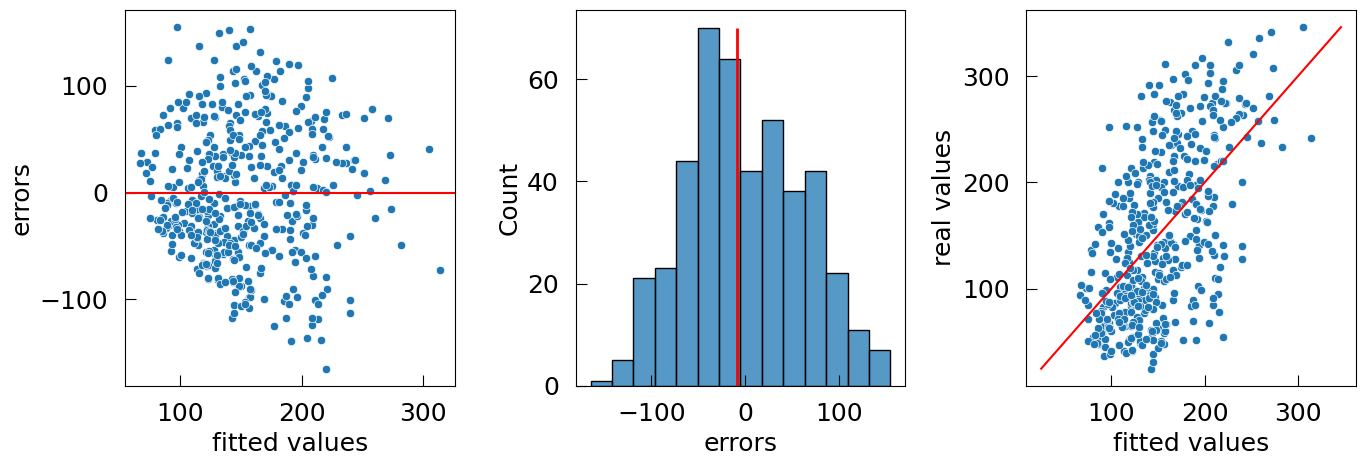

In [19]:
fig, ax = plt.subplots(ncols=3, figsize = (14,5)) #setup graphical windows
# plot the residuals along fitted values
sns.scatterplot(x=results.fittedvalues,
                y=results.resid , 
                ax=ax[0]) 
ax[0].axhline(0,color='red')
ax[0].set_ylabel('errors')
ax[0].set_xlabel('fitted values')

# histogram of residuals
sns.histplot(results.resid , ax=ax[1]) # plot an histogram of the errors
ax[1].vlines( np.median( results.resid ) ,0,70 , color="red", linewidth = 2)
ax[1].set_xlabel('errors')


sns.scatterplot(x=results.fittedvalues,
                y=df_diabetes["disease_progression"] , 
                ax=ax[2]) 
m,M = min(df_diabetes["disease_progression"]) , max(df_diabetes["disease_progression"])
ax[2].plot([m,M],[m,M], color='red')
ax[2].set_ylabel('real values')
ax[2].set_xlabel('fitted values')

fig.tight_layout()

**Mini-exercise : what is your conclusion on the $bmi$ model based on these results ?**

[back to the toc](#toc)

<br>

## 1.5. building and fitting OLS models with `statsmodels`  <a id='4b'></a>


There  are two main approach to building a model with `statsmodels`.

The first is the one we juste demonstrated: giving an iterable representing the target variable (`y`), and a 2D numpy array representing all covariables, including the intercept (`X`).

The second is to use a *formula*. If you have been doing some regression in R, you would have come across these : instead of different dataframes for dependent variable covariables, on gives a single `DataFrame` along with a formula of the type `y ~ x`.

As long as you have regrouped all your variables of interest in the same `DataFrame`, this second solution offers a fairly simple and elegant way of specifying your model, with an efficient handling of intercepts, as well as interaction effects.



In [20]:
## option 1 : using different matrices for target / covariables

y = df_diabetes['disease_progression'] # response variable disease progression
X = sm.add_constant( df_diabetes['bmi'] )## adding the intercept to the model

model1 = sm.OLS(y, X)

## option 2 : using a formula
import statsmodels.formula.api as smf

model2 = smf.ols("disease_progression ~ bmi" , data = df_diabetes) 
## NB : the intercept is implicit here. To have a model without intercept: disease_progression ~ 0 + bmi


Whichever method you end up using, you need to fit you model:

In [21]:
results1 = model1.fit()
results2 = model2.fit()

In [22]:
## both method give the same result:
print("method 1")
print(results1.params)
print("method 2")
print(results2.params)

method 1
const    152.133484
bmi      949.435260
dtype: float64
method 2
Intercept    152.133484
bmi          949.435260
dtype: float64


> Going into details on these formula is beyond the scope of this course, but we encourage you to go though this [very well made tutorial](https://www.statsmodels.org/devel/example_formulas.html)

**Let's now proceed to an OLS fitting on a toy model produced thanks to the relation** $\pmb Y=-3x+6x^3+1$

Text(0, 0.5, 'y')

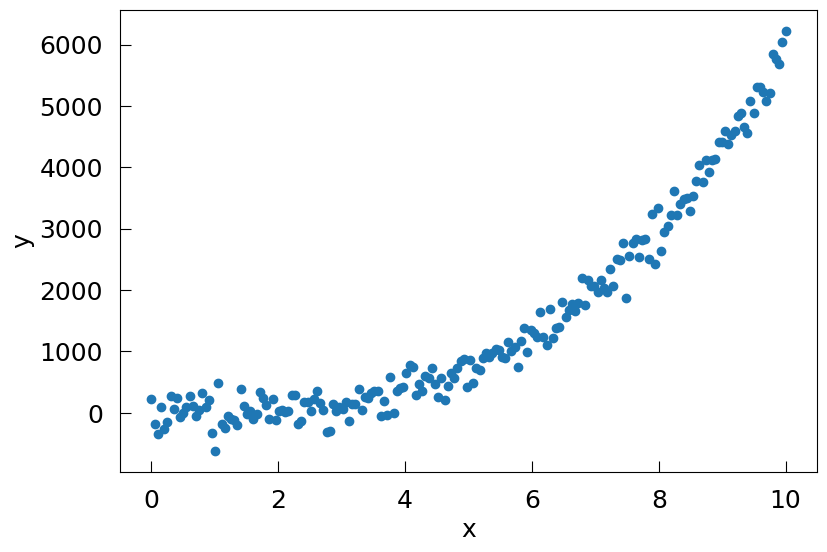

In [23]:
###making toy data
nsample = 200
x = np.linspace(0, 10, nsample)#this is our covariable
X = np.column_stack((x, x**3)) #here with have only one real covariable, 
#but we will increase that number by also considering it's cube in our model


#the true value of our parameters associated to our covariables 
# bonus : try 1,-100,2
beta = np.array([1, -3, 6])

#for now noise is low, but you can play with it by increasing the scale
e = nsample*np.random.normal(size=nsample , scale=1)


X = sm.add_constant(X)  ##adding the intercept
y = np.dot(X, beta) + e ## making y=1-3x+6x^3 + noise
y_true=np.dot(X, beta)

plt.subplots(figsize = (9,6)) #setup graphical windows
plt.plot(x,y,'o')
plt.xlabel('x')
plt.ylabel('y')

In [24]:
model = sm.OLS(y, X)  ##defining an Ordinary Least Square variable
results = model.fit() ##fitting it

res=results.summary()
print(res)
LMstat , LMpval , Fstat , Fpval = het_white( results.resid , X )
print("\n\tWhite test for heteroscedasticity p-value:" , LMpval)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     7060.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):          4.48e-184
Time:                        15:09:50   Log-Likelihood:                -1343.4
No. Observations:                 200   AIC:                             2693.
Df Residuals:                     197   BIC:                             2703.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3870     37.704      0.355      0.7

Let's also plot the result :

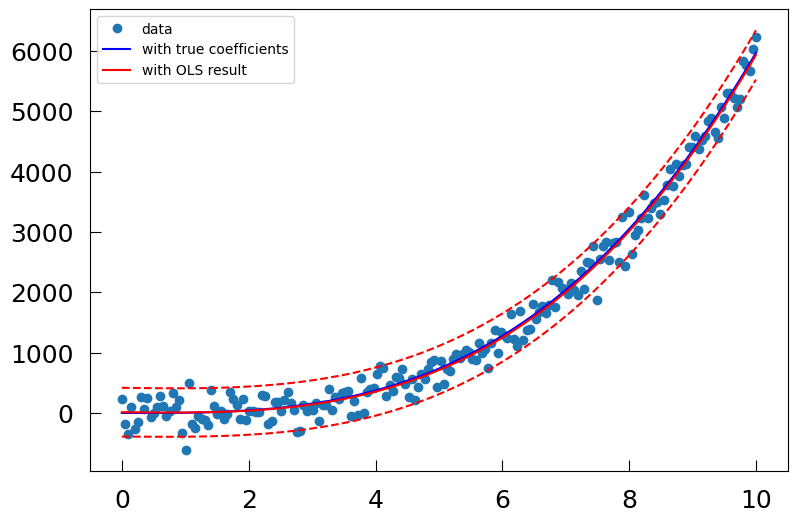

In [25]:
###Plotting the fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# we obtain the predicted values for our model, as well as their 95% intervals
prstd, iv_l, iv_u = wls_prediction_std(results) 

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="with true coefficients")
ax.plot(x, results.fittedvalues, 'r', label="with OLS result")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best',fontsize=10)

**Mini-exercise : given these results (plot + result summary), what is your conclusion on this model ?**


[back to the toc](#toc)

<br>

# Exercise on a real dataset : model the effect of park frequentation on sparrow nest number with a cubic function <a id='6'></a>



Using data from [TESTING THE RISK-DISTURBANCE HYPOTHESIS IN A FRAGMENTED LANDSCAPE: NONLINEAR RESPONSES OF HOUSE SPARROWS TO HUMANS
Fernández-Juricic(2003),BioOne](https://bioone.org/journals/the-condor/volume-105/issue-2/0010-5422(2003)105%5b0316%3aTTRHIA%5d2.0.CO%3b2/TESTING-THE-RISK-DISTURBANCE-HYPOTHESIS-IN-A-FRAGMENTED-LANDSCAPE/10.1650/0010-5422(2003)105[0316:TTRHIA]2.0.CO;2.short)

In this data set we would like to model the relation between the density of house sparrow nests in a park and how popular a park is.

In [26]:
df=pd.read_csv("data/Human_nuisance.csv", index_col=0)
df = df.rename( columns = {"Breeding density(individuals per ha)" : "Breeding" , 
            "Number of pedestrians per ha per min" : "Number" } )
df.head()

,Breeding,Number
0,7.974940,0.851146
1,33.316187,3.973849
2,60.407007,5.955376
3,89.562266,5.959888
4,74.250691,6.039171


Text(0.5, 0, 'Number of pedestrians per ha per min')

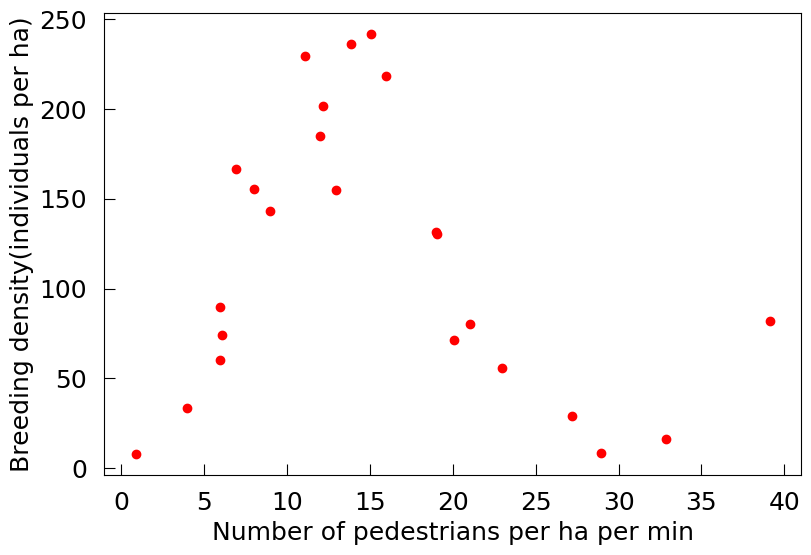

In [27]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot( df['Number'], df['Breeding'],'ro')
ax.set_ylabel("Breeding density(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")

Perform an OLS regression analysis on this data, to explain the swallow breeding density (response variable) with the number of pedestrian (covariable).

> The relationship between the two variable implies at most a cubic (\*\*3) relation

In [28]:
# %load solutions/solution_01_01.py


[back to the toc](#toc)

<br>

## 1.6. Model choosing <a id='8'></a>

Most of the time you are not sure of the model you want to fit. You might have a broad idea of the different forms of the function but you don't really know for example what would be the best degree for your poynomial or if all the covariables are actually necessary. Of course you could say "I am keeping the model that fit the best in term of $R^2$". But the question really is : is that bunch of extra parameters that are complexifying my model worth the increase in $R^2$?

We touched that question in 1.4 by asking about the significance of parameters values. Again if you are confident on the noise distribution you are dealing with (let's say it is normally distributed), and you have a function in mind but you don't know if you should include 1,2 or $p$ covariables then the problem is easy: you can use a log-likelihood ratio test.


### Likelihood ratio test (LRT)

We already mentioned the likelihood, or log-likelihood, several time. 

We will not spend too long here on its precise definition, in part because we will discuss it in some details in the next chapter. Suffice to know for now the **likelihood is a metric of goodness of fit of your model to your data** which possess interesting mathematical properties when it comes to comparing different models. 

Furthermore, it is computed for you by `statsmodels.OLS` and is part of the fit summary.


To perform a Likelihood Ratio Test you just have to calculate the difference between the maximised log-likelihood of the two models you are comparing. 
You can estimate the significance of that difference either by using a test statistic (approximate method, which we will show) or by using simulations.

LRT are to be used in the case of **nested function comparisons**. Nested functions are functions that have the same form but differ in the number of parameters used : for example comparing $y=\beta_1 x_1 +c$ and $y=\beta_1 x_1 +\beta_2 x_2 +c$. In this course this will always be the case (but just remember that outside of this course you might want to do other comparison, so be careful).

**Briefly :**

You want to compare model $M_0$ and $M_1$, respectively having $\{\beta_{1,0}\}$ and $\{\beta_{1,2},\beta_{2,2}\}$ as parameters. You want to see if adding this extra parameter $\beta_{2,2}$ is worth it.

The LRT statistics is :

$$2*(l(X;\hat{\beta}_{1,2},\hat{\beta}_{2,2})-l(X;\hat{\beta}_{1,0}))$$

Where the hat represents the maximum likelihood estimates. 

The LRT statistic asymptoptically, for your sample size going to infinity, follows a **chi-square distribution with a number of degree of freedom equal to the difference between the number of parameters in your models**. You have thus access to a P-value which will help you to decide if complexifying your model is worth it. 

Typically this LRT statistic could be viewed as a difference in terms of goodness of fit. If this difference is big compared to the goodness of fit of the model with fewer parameters then it is interesting to keep the complexified model. 

Indeed if this LRT statistic is big then the P-value will be low, and you will tend to reject the null hypothesis that the two models have the same (or non-significatively different) goodness of fit to your data.

> Note how in the LRT statistic I have put the complex model first then the simple model.


To calulate this P-value you can use $1-scipy.stats.chi2.cdf(LRT,df_{M_1}-df_{M_0})$, where $df$ is the number of degree of freedom of the models, equivalent to the number of parameters in our case.

Just to clarify again : **you want to go for the model with the least number of parameters and for which adding more parameters doesn't signicantly increase the goodness of fit**.

#### Example of model choosing : on diabetes

In [29]:
ordered_covariables=['bmi', 's5', 'bp', 's3', 's2']
y=np.array(diabetes['target'])#making this data set into an array
list_co=[]#list of covariable

logLikelihood_dict = {}
result_dict = {}
modelNameList = []

for i, p in enumerate( ordered_covariables ):# we will add covariables 1 by 1
    
    list_co.append( p ) ## add a covariable

    ## building the model
    formula = 'disease_progression ~ ' + ' + '.join(list_co)
    
    model = smf.ols( formula ,data=df_diabetes) # define your least square object
    results = model.fit() # fitting
    
    # report
    print('\n',formula)
    print("\tadjusted R-squared: {:.3f}\tlog-likelihood: {:.3f}".format(results.rsquared_adj,
                                                                        results.llf) )
    #save the results
    n='+'.join(list_co)
    modelNameList.append( n )
    logLikelihood_dict[ n ] = results.llf
    result_dict[ n ] = results


 disease_progression ~ bmi
	adjusted R-squared: 0.342	log-likelihood: -2454.019

 disease_progression ~ bmi + s5
	adjusted R-squared: 0.457	log-likelihood: -2411.199

 disease_progression ~ bmi + s5 + bp
	adjusted R-squared: 0.477	log-likelihood: -2402.613

 disease_progression ~ bmi + s5 + bp + s3
	adjusted R-squared: 0.487	log-likelihood: -2397.706

 disease_progression ~ bmi + s5 + bp + s3 + s2
	adjusted R-squared: 0.491	log-likelihood: -2395.582


In [30]:
p_value_threshold=0.01## what you would consider as significant or not : 
# i.e if you will consider adding the parameter or not

# we start with the model that has a single covariable
sel_name = modelNameList[0]
sel_loglkh = logLikelihood_dict[ sel_name ]

# we are going through the list of models following their order in goodness of fit
for mName in modelNameList[1:] : # from the second model to the last one
    
    loglkh = logLikelihood_dict[ mName ]
    
    LRT = 2*( loglkh - sel_loglkh )
    
    # By definition they differ by 1 parameter, so the degree of freedom of the Chi-square distribution is 1
    pval = 1-stats.chi2.cdf( LRT , 1 )#calculating the pvalue that compares the goodness of fit of the two models
    
    if pval < p_value_threshold:
        print("The log likelihood difference between model {0} and model {1}".format(mName,sel_name))
        print(" is associated to a P-value={0:.3f}\n".format(pval))
        ## update selected model:
        sel_name = mName
        sel_loglkh = loglkh
    else:
        print("The log likelihood difference between model {0} and model {1}".format(mName,sel_name))
        print(" is associated to a non-significant P-value={0:.3f}\n".format(pval))
        break # we stop has soon as the addition of a covariable does not significantly increase the log likelihood

The log likelihood difference between model bmi+s5 and model bmi
 is associated to a P-value=0.000

The log likelihood difference between model bmi+s5+bp and model bmi+s5
 is associated to a P-value=0.000

The log likelihood difference between model bmi+s5+bp+s3 and model bmi+s5+bp
 is associated to a P-value=0.002

The log likelihood difference between model bmi+s5+bp+s3+s2 and model bmi+s5+bp+s3
 is associated to a non-significant P-value=0.039



In [31]:
print( result_dict[sel_name].summary() )

                             OLS Regression Results                            
Dep. Variable:     disease_progression   R-squared:                       0.491
Model:                             OLS   Adj. R-squared:                  0.487
Method:                  Least Squares   F-statistic:                     105.6
Date:                 Tue, 06 Dec 2022   Prob (F-statistic):           7.24e-63
Time:                         15:09:50   Log-Likelihood:                -2397.7
No. Observations:                  442   AIC:                             4805.
Df Residuals:                      437   BIC:                             4826.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.1335      2.627     57.91


[back to the toc](#toc)

<br>

## 1.7. What to do when some hypothesis about OLS are not true <a id='7'></a>


When the homoscedasticity of your data is not true you have a few possibilities:
- you can transform your data so your data become homoscedastic (for example you could use a variance stabilizing transformation, or a simple log transform or other...)
- you can change $S(\beta)$, your loss function, to reweight the different members of that equation by taking into account the discrepancy in terms of variance. That only works if there is no correlation between the error terms. In that case the method is called [**Weighted Least Square**](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.WLS.html#statsmodels.regression.linear_model.WLS) and the loss function becomes 
$$S(\pmb\beta)=\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 \rightarrow S(\pmb\beta)=\sum_i \frac{1}{\sigma_i^2} (y_i-f(\pmb X_i,\pmb{\beta}))^2$$
- if there is a correlation between the different error terms then it becomes more complicated, but technics exist such as [Generalized Least Square model](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.GLS.html#statsmodels.regression.linear_model.GLS)

Finally **if you know  what statistics your measurement follow**, you can bypass all of those problems (and encounter others :-)) by using a **Maximum Likelihood approach** rather than an Least-Square method. 

By doing so you will have to put yourself in the framework of Generalized Linear Models.




[back to the toc](#toc)

<br>

# Exercise : model choosing on the sparrow nuisance dataset <a id='9'></a>


Come back to the sparrow dataset (`df_nuisance`).

Find the best model possible (i.e., change the degree of the polynomial we try to fit).

In [32]:
# %load -r -13 solutions/solution_01_02.py

In [33]:
# %load -r 14- solutions/solution_01_02.py


[back to the toc](#toc)

<br>

# Going further : interaction effects <a id='11'></a>

So far the models we have created consider each co-variable effects independently. 
However it is legitimate to want to consider interactions effect between in certain cases.

While you could add interaction effects yourselves by adding columns consisting of the multiplication of several covariables into your dataframe of covariables, we highly recommend you use the syntax offered by formulas. For instance,  a `*` or `:` instead of a `+` when specifying covariables will, respectively, add each variables and their interaction effect, or add only the interaction effect.





# Going further : get statsmodels summaries as pandas DataFrame

These summaries given by statsmodels are great, but they can be a hassle to handle programmatically. Here is a little recipe to transform them in pandas DataFrame.

In [34]:
from io import StringIO

#### a little bit of gymnastic to get this summary saved and usable.
def make_summary_tables( res ):
    """ takes a summary from statsmodel fitting results and turn it into 2 dataFrame.
            - result_general_df : contains general info and fit quality metrics
            - result_fit_df : coefficient values and confidence intervals
    """

    # transform second table to csv and read this as a dataFrame
    result_fit_df = pd.read_csv(StringIO( res.tables[1].as_csv() ), sep=",",index_col=0)

    # first table is trickier because the data is spread on to columns, and there is title line
    L = res.tables[0].as_html().split('\n')
    L.pop(1) # get rid of the title
    tmp = pd.read_html('\n'.join(L) , header=None)[0] # read as a dataframe, but with 4 columns 

    names = list(tmp[0]) + list(tmp[2])[:-2] # columns 0 and 2 are metric names
    values = list(tmp[1]) + list(tmp[3])[:-2] # columns 1 and 3 are the corresponding values
    # NB : I exclude the last 2 elements which are empty 
    
    result_general_df = pd.DataFrame( {'Name': names , 'Value' : values}, index = names , columns=['Value'] )
    
    return result_general_df , result_fit_df

result_general_df , result_fit_df = make_summary_tables( res )

In [35]:
# I have put the overall recap of the fit in a dataframe format so you can use it later
result_general_df

,Value
Dep. Variable:,y
Model:,OLS
Method:,Least Squares
Date:,"Tue, 06 Dec 2022"
Time:,15:09:50
No. Observations:,200
Df Residuals:,197
Df Model:,2
Covariance Type:,nonrobust
R-squared:,0.986


In [36]:
# I have put the outcome of the fit in a dataframe format so you can use it later
result_fit_df

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
const,13.3870,37.704,0.355,0.723,-60.968,87.741
x1,-11.3394,12.241,-0.926,0.355,-35.480,12.801
x2,6.0346,0.124,48.516,0.000,5.789,6.280
